# Task 1 - EDA (Brent Oil Prices)

This notebook covers initial exploration for the Week 11 change point analysis project:
- Load and clean Brent oil prices.
- Visualize price levels and log returns.
- Check stationarity and volatility patterns.
- Save key figures to `outputs/figures`.


In [5]:
# Imports and data loading
from pathlib import Path
import sys

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Ensure project root is on the path for src imports
sys.path.insert(0, str(Path("..")))

from src.utils.plotter import Plotter

DATA_PATH = Path("../data/raw/BrentOilPrices.csv")
OUTPUT_DIR = Path("../outputs/figures")
plotter = Plotter(figures_dir=OUTPUT_DIR)

df = pd.read_csv(DATA_PATH)
# Mixed date formats exist in the file; infer per-row and coerce invalid values
df["Date"] = pd.to_datetime(df["Date"], format="mixed", dayfirst=True, errors="coerce")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

df = df.dropna(subset=["Date", "Price"]).sort_values("Date").reset_index(drop=True)

df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


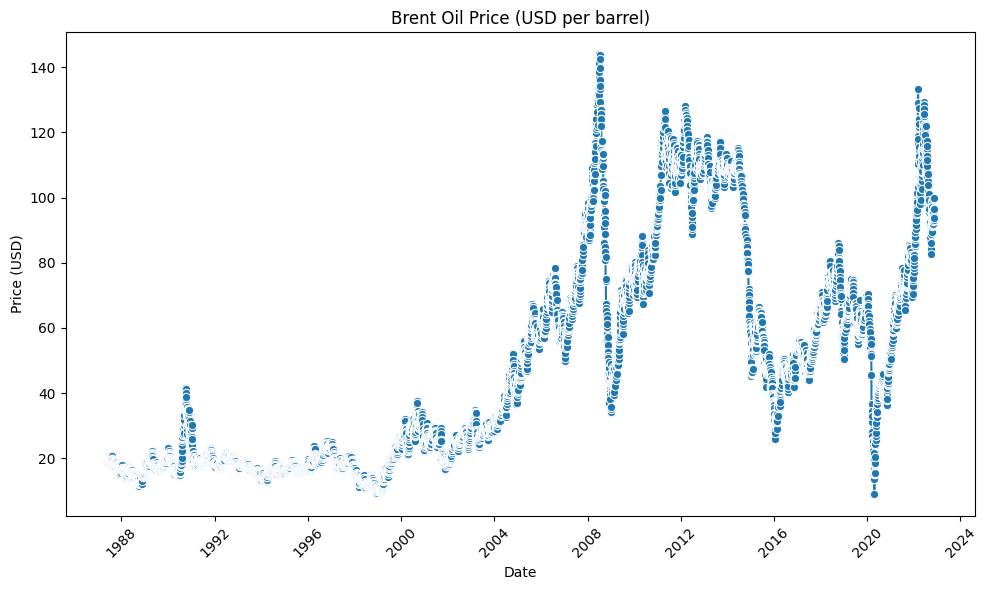

In [6]:
# Price series plot (via Plotter)
plotter.plot_time_series(
    df,
    date_col="Date",
    value_col="Price",
    title="Brent Oil Price (USD per barrel)",
    xlabel="Date",
    ylabel="Price (USD)",
)

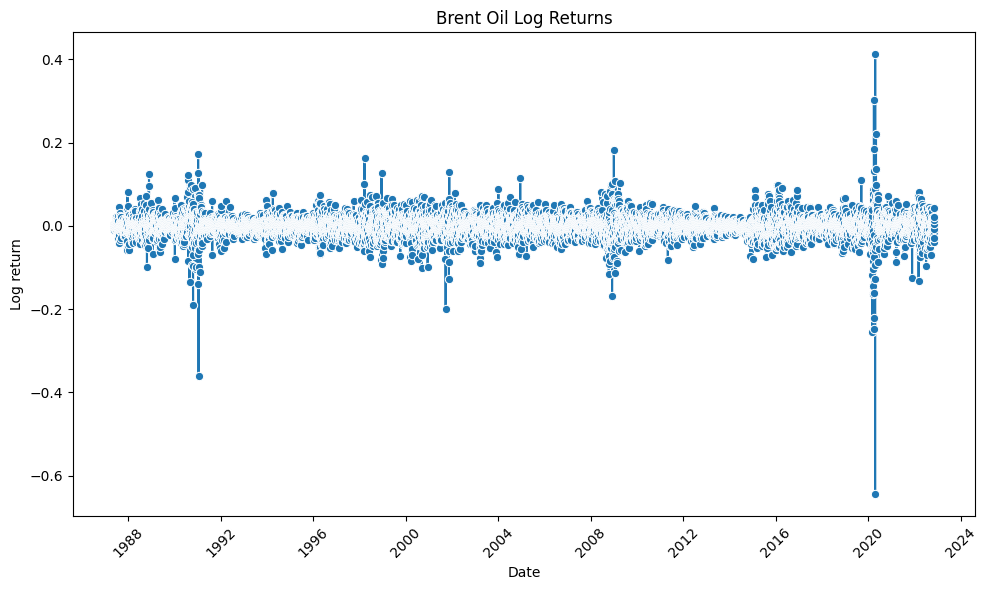

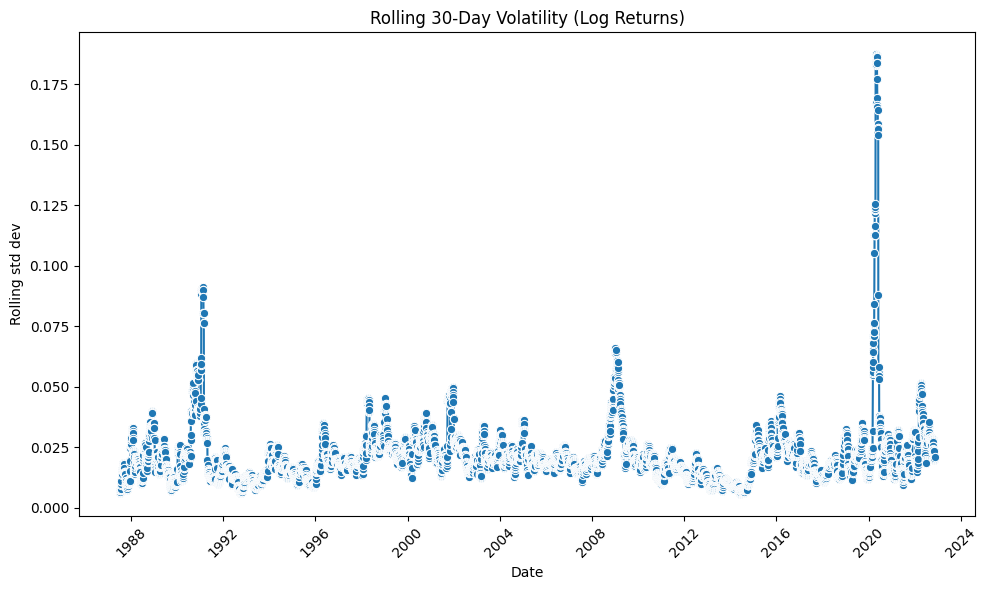

In [7]:
# Log returns and volatility (via Plotter)
log_price = np.log(df["Price"])
df["log_return"] = log_price.diff()

df_lr = df.dropna(subset=["log_return"])
plotter.plot_time_series(
    df_lr,
    date_col="Date",
    value_col="log_return",
    title="Brent Oil Log Returns",
    xlabel="Date",
    ylabel="Log return",
)

# Rolling volatility (30-day)
df["log_return_vol_30d"] = df["log_return"].rolling(30).std()
df_vol = df.dropna(subset=["log_return_vol_30d"])
plotter.plot_time_series(
    df_vol,
    date_col="Date",
    value_col="log_return_vol_30d",
    title="Rolling 30-Day Volatility (Log Returns)",
    xlabel="Date",
    ylabel="Rolling std dev",
)

In [8]:
# Stationarity check (ADF) on log returns
adf_series = df_lr["log_return"].dropna()
result = adfuller(adf_series, autolag="AIC")

adf_output = {
    "adf_statistic": result[0],
    "p_value": result[1],
    "n_lags": result[2],
    "n_obs": result[3],
}

adf_output

{'adf_statistic': np.float64(-16.427113494485894),
 'p_value': np.float64(2.4985801611428892e-29),
 'n_lags': 28,
 'n_obs': 8981}

## Summary

- Cleaned and parsed Brent oil prices with mixed date formats and numeric coercion.
- Visualized price levels, log returns, and 30-day rolling volatility using the shared `Plotter`.
- ADF test on log returns indicates strong stationarity (p-value ≪ 0.01).

## Figure Index (PNG)

| Figure | Description | Output file |
|---|---|---|
| 1 | Brent Oil Price (USD per barrel) | `../outputs/figures/brent_oil_price.png` |
| 2 | Brent Oil Log Returns | `../outputs/figures/brent_oil_log_returns.png` |
| 3 | Rolling 30-Day Volatility (Log Returns) | `../outputs/figures/brent_oil_volatility_30d.png` |

## Description

The analysis confirms that the price series shows long-term trends, while log returns are mean-reverting with volatility clustering. The ADF result supports stationarity of log returns, making them suitable for downstream change-point modeling.